# Importing:

In [45]:
import pdb
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from tqdm import trange
import pandas as pd

# Full Neural Network Training Step
1. **Forward Pass**
* **Input data** $X$ is fed into the network.
* Data flows through each **layer**, which usually consists of:

  * **Linear/weight layers**: compute $Z = XW + b$
  * **Activation layers**: apply non-linear function $A = f(Z)$ (like ReLU, Softmax)
* Final layer produces output $\hat{y}$ (e.g., class probabilities).
* Compute the **loss** $L(\hat{y}, y)$ comparing output to true labels $y$.

2. **Backward Pass (Backpropagation)**
Goal: calculate gradients of loss w\.r.t. **all parameters** (weights and biases), so you can update them with gradient descent.

2.1. **Compute gradient of loss w\.r.t. output layer output**

* Using loss function derivative, e.g., for cross-entropy loss combined with softmax:

$$
\frac{\partial L}{\partial \hat{y}} = \hat{y} - y
$$

2.2. **Backprop through output activation (if separate)**

* If softmax is separate, calculate gradient of loss w\.r.t. softmax input $Z$ using Jacobian or simplified form above.
* If softmax + cross-entropy are combined, this step is usually optimized.

Step 2.3: Backprop through each layer **in reverse order**

For each layer going backward:

* **Activation layers (like ReLU):**

  $$
  \frac{\partial L}{\partial Z} = \frac{\partial L}{\partial A} \odot f'(Z)
  $$

  * Multiply upstream gradient by derivative of activation (element-wise).

* **Weight layers (like Dense/Fully connected):**

  $$
  \frac{\partial L}{\partial W} = X^T \cdot \frac{\partial L}{\partial Z}
  $$

  $$
  \frac{\partial L}{\partial b} = \sum \frac{\partial L}{\partial Z}
  $$

  $$
  \frac{\partial L}{\partial X} = \frac{\partial L}{\partial Z} \cdot W^T
  $$

  * Calculate gradient w\.r.t weights and biases.
  * Calculate gradient w\.r.t input to pass to the previous layer.

3. **Update weights**

* Use gradients to update weights with gradient descent or a variant, e.g.,

$$
W := W - \eta \frac{\partial L}{\partial W}
$$

where $\eta$ is the learning rate.
---
Full Example: Simple 2-layer network (Dense + ReLU + Dense + Softmax)

* Forward pass:

  ```
  X -> Dense1 -> Z1
  Z1 -> ReLU -> A1
  A1 -> Dense2 -> Z2
  Z2 -> Softmax -> output probabilities
  ```

* Backward pass:

  ```
  dL/dOutput = (output - true_labels)  # for softmax + cross-entropy
  dL/dZ2 = dL/dOutput
  dL/dA1 = Dense2.backward(dL/dZ2)
  dL/dZ1 = ReLU.backward(dL/dA1)
  dL/dX = Dense1.backward(dL/dZ1)
  ```

---



# Implement the Neural Network:

## Abstract Layer Class

In [46]:
class Layer:
    def __init__(self):
        self.inp  = None 
        self.out = None

    def __call__(self, inp: np.ndarray) -> np.ndarray:
        return self.forward(inp)
    
    def forward(self, inp: np.ndarray) -> np.ndarray:
        raise NotImplementedError
    
    def backward(self, up_graad: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def step(self, learning_rate: float) -> None:
        pass        

## Linear Layers:

**Initialization**
- `self.w`: Represents the weight matrix of shape `(in_dim, out_dim)`, initialized using small random values.
- `self.b`: Bias vector of shape `(1, out_dim)`, initialized to zeros.
- `self.dw` and `self.db`: These store the computed gradients of weights and biases during backpropagation.




**Forward Pass**
- The forward pass computes:
$$\mathbf{out} = \mathbf{inp} \cdot \mathbf{W} + \mathbf{b}$$
where:
  - `inp`: inp matrix of shape `(batch_size, in_dim)`
  - `self.w`: Weight matrix of shape `(in_dim, out_dim)`
  -	`self.b`: Bias matrix of shape `(1, out_dim)`
-	The result is a matrix out of shape `(batch_size, out_dim)`.




## **Backward Pass**
- The backward pass computes gradients needed for updating the weights and biases. Given the upstream gradient `up_grad` (from the loss with respect to the output of this layer), we calculate:
  - Gradient w.r.t. weights (`self.dw`):
    $ \frac{\partial L}{\partial W} = \mathbf{inp}^T \cdot \text{up\_grad} $
  - Gradient w.r.t. biases (`self.db`):
    $ \frac{\partial L}{\partial b} = \sum \text{up\_grad} \text{ (summed across batch)} $
  - Gradient to propagate to the previous layer (`down_grad`):
    $ \text{down\_grad} = \text{up\_grad} \cdot W^T $
- This allows the gradient to flow backward to earlier layers.





**Step Method**
- Updates the weights and biases using the computed gradients and learning rate (`learning_rate`):
    $$W = W - lr \cdot \frac{\partial L}{\partial W}$$
    $$b = b - lr \cdot \frac{\partial L}{\partial b}$$


In [47]:
class Linear(Layer):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        # HE initialization:
        self.w  = 0.1 * np.random.randn(in_dim, out_dim)
        #self.w = np.random.randn(in_dim, out_dim) * np.sqrt(2. / in_dim)  # He initialization
        self.b  = np.zeros((1, out_dim))
        self.dw = np.zeros_like(self.w)
        self.db = np.zeros_like(self.b) 
    
    def forward(self, inp: np.ndarray) -> np.ndarray:
        """Perform the linear transformation: output = inp * W + b"""
        self.inp = inp
        self.out = np.dot(inp, self.w) + self.b
        return self.out
    
    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        """ Backpropagate the gradients through this layer: """
        # dw = round L / round w 
        self.dw = np.dot(self.inp.T, up_grad)
        # dw = round L / round b
        self.db = np.sum(up_grad, axis=0, keepdims=True)

        down_grad = np.dot(up_grad, self.w.T)
        return down_grad
    
    def step(self, learning_rate: float) -> None:
        self.w -= learning_rate * self.dw
        self.b -= learning_rate * self.db

## Activation Functions:


### ReLU

In [48]:
class ReLU(Layer):
    def forward(self, inp: np.ndarray) -> np.ndarray:
        """ReLU Activation function: f(x) = max(0, x)"""
        self.inp = inp
        self.out = np.maximum(0, inp)
        return self.out
    
    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        """Backward pass for ReLU: derivative is 1 where input > 0, else 0."""
        down_grad = up_grad * (self.inp > 0)  # Efficient boolean indexing
        return down_grad

### Softmax:

In [49]:
class Softmax(Layer):
    def forward(self, inp: np.ndarray) -> np.ndarray:
        """Softmax activation: f(x) = exp(x) / sum(esp(x))"""
        # subtract max for numerical stability:
        exp_values = np.exp(inp - np.max(inp, axis=1, keepdims=True) )
        self.out   = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return self.out

    def backward(self, up_grad: np.ndarray) -> np.ndarray:
        """Backward pass for Softmax using the Jacobian matrix."""
        down_grad = np.empty_like(up_grad)
        for i in range(up_grad.shape[0]):
            single_output = self.out[i].reshape(-1, 1)
            jacobian      = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            down_grad[i]  = np.dot(jacobian, up_grad[i])
        return down_grad
        

#### Why does softmax use the Jacobian as a derivative:
A Jacobian is used when the output of a function depends on all inputs.
Thanks for pointing that out — let's slow it down and **explain what it means for a function to be element-wise**, and why that matters for backpropagation.

---

What does *element-wise* mean?

When we say a function is **element-wise**, we mean that:

> **Each output value depends on exactly one input value**, and not on the others.

In symbols:
* Input: $x = [x_1, x_2, x_3]$
* Output: $y = f(x) = [f(x_1), f(x_2), f(x_3)]$
Each $y_i = f(x_i)$, completely **independent** of the other $x_j$
---
Example: ReLU is element-wise

```python
def relu(x):
    return np.maximum(0, x)
```
Input:

```python
x = [-2, 3, -1]
```
Output:

```python
relu(x) = [0, 3, 0]
```

* The output at position 0 (which is 0) comes **only** from the input at position 0 (which is -2).
* It does **not** depend on `x[1]` or `x[2]`.

So we can compute the derivative (gradient) for each position **individually**:

$$
\frac{\partial y_i}{\partial x_i} = 
\begin{cases}
1 & \text{if } x_i > 0 \\
0 & \text{if } x_i \leq 0
\end{cases}
$$

And this is why the backward pass is so simple:

```python
down_grad = up_grad * (self.inp > 0)
```

Just multiply the gradient at each index by either 1 or 0 — no interference between indices.

---

Softmax is **not** element-wise:
$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_j e^{z_j}}
$$
That means each output $y_i$ is:
* a fraction that includes **every** $z_j$ in the denominator.
So the output $y_0$ depends on:
* $z_0$, because of the numerator,
* **and** all $z_j$ (including $z_1, z_2, ...$) because they’re in the denominator.
Same goes for $y_1, y_2$, etc.

Result:

* Changing one input $z_j$ affects **all** outputs $y_i$
* So we can't compute the derivative of $y_i$ w\.r.t. $z_j$ independently
* That’s why we need the **Jacobian matrix**, to keep track of **how every input affects every output**



| Layer   | Formula                                   | Output depends on…    | Needs Jacobian? |
| ------- | ----------------------------------------- | --------------------- | --------------- |
| ReLU    | $f(x_i) = \max(0, x_i)$                   | Only one input $x_i$  | ❌ No            |
| Softmax | $f(x_i) = \frac{e^{x_i}}{\sum_j e^{x_j}}$ | All inputs $x_0..x_n$ | ✅ Yes           |

---

In backpropagation:

* For **ReLU**, it's enough to use a simple mask.
* For **Softmax**, you must account for all interactions — which is what the Jacobian matrix does.



## Loss Functions:

### Abstrac Loss Function:

In [50]:
class Loss:
    def __init__(self):
        self.predicted = None
        self.target    = None
        self.loss      = None
    
    def __call__(self, prediction: np.ndarray, target: np.ndarray) -> float:
        return self.forward(prediction, target)
    
    def forward(self, prediction:np.ndarray, target: np.ndarray) -> float:
        raise NotImplementedError
    
    def backward(self) -> np.ndarray:
        raise NotImplementedError        

## Cross-Entropy Loss

Cross-entropy loss is typically used in classification tasks since it measures the dissimilarity between the true distribution (target) and the predicted probability distribution (prediction):

$$L = - \frac{1}{N} \sum_{i} \sum_{c} y_{ic} \log(p_{ic})$$

where $y_{ic}$ is the one-hot encoded true label (target), $p_{ic}$ is the predicted probability (output from Softmax) and $N$ is the batch size.


In [51]:
class CrossEntropy(Loss):
    def forward(self, prediction: np.ndarray, target: np.ndarray) -> float:
        """Cross-Entropy Loss for classification."""
        self.prediction = prediction
        self.target = target
        # Clip predictions to avoid log(0)
        clipped_pred = np.clip(prediction, 1e-12, 1.0)
        # Compute and return the loss
        self.loss = -np.mean(np.sum(target * np.log(clipped_pred), axis=1))
        return self.loss

    def backward(self) -> np.ndarray:
        """Gradient of Cross-Entropy Loss."""
        # Gradient wrt prediction (assuming softmax and one-hot targets)
        grad = -self.target / self.prediction / self.target.shape[0]
        return grad

## Neural Network:

In [52]:
class MLP:
    def __init__(self, layers: list[Layer], loss_func: Loss, learning_rate: float) -> None:
        self.layers        = layers
        self.loss_func     = loss_func
        self.learning_rate = learning_rate
    
    def __call__(self, input: np.ndarray) -> np.ndarray:
        return self.forward(input)
    
    def forward(self, input: np.ndarray) -> np.ndarray:
        """ pass input through each layer sequentially """
        for layer in self.layers:
            input = layer.forward(input)
        return input
    
    def loss(self, prediction: np.ndarray, target: np.ndarray) -> float:
        """Calculate Loss"""
        return self.loss_func(prediction, target)
    
    def backward(self) -> None:
        up_grad = self.loss_func.backward()
        for layer in reversed(self.layers):
            up_grad = layer.backward(up_grad)
    
    def update(self) -> None:
        for layer in self.layers:
            layer.step(self.learning_rate)
    
    def train(self, x_train: np.ndarray, y_train: np.ndarray, epochs: int, batch_size: int) -> np.ndarray:
        losses = np.empty(epochs)
        for epoch in (pbar := trange(epochs)):
            running_loss = 0.0
            for i in range(0, len(x_train), batch_size):
                x_batch = x_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]

                #Forward pass:
                prediction = self.forward(x_batch)

                #Compute loss:
                running_loss += self.loss(prediction, y_batch) * batch_size

                #Backward pass:
                self.backward()

                #Update the parameters:
                self.update()
            
            #Normalize running loss by total number of samples:
            running_loss /= len(x_train)
            pbar.set_description(f"Loss: {running_loss:.3f}")
            losses[epoch] = running_loss

        return losses

# Use MLP to solve a problem: 

## Investigating the Fashion-MNIST dataset:

In [36]:
fashion_mnist = fetch_openml("Fashion-MNIST", parser='auto')

In [37]:
print(type(fashion_mnist))
print(f"type of the fashion_mnist: {type(fashion_mnist)} \n")
print(f"keys of the fashion_mnist: {fashion_mnist.keys()}")

<class 'sklearn.utils._bunch.Bunch'>
type of the fashion_mnist: <class 'sklearn.utils._bunch.Bunch'> 

keys of the fashion_mnist: dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


### Examining data:

In [38]:
print(type(fashion_mnist['data']))

<class 'pandas.core.frame.DataFrame'>


In [39]:

print(f"shape of the dataset: {fashion_mnist['data'].shape}")
print(f"data of the fashion_mnist: {fashion_mnist['data'].head()}")


shape of the dataset: (70000, 784)
data of the fashion_mnist:    pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       1       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0      33   
4       0       0       0       0       0       0       0       0       0   

   pixel10  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0        0  ...         0         0         0         0         0         0   
1        0  ...       119       114       130        76         0         0   
2       22  ...         0         0         1         0         0         0   
3       96  ...         0         0         0         0         0         0   
4        0  ...         0         0         0         0         0         0   



#### Indexing explained:
- fashion_mnist['data'].shape[0] = 70000 → number of images (indexes from 0 to 69999).
- fashion_mnist['data'].shape[1] = 784 → number of pixels in each image (indexes from 0 to 783)

#### So:
- When you do fashion_mnist['data'][index] — you are selecting the entire image at that row index (a 1D array of 784 pixels).

- When you do fashion_mnist['data'][index][pixel] — you are selecting a single pixel value from the image at index.


In [40]:
# Access first row (image 0) in the DataFrame
first_image_row = fashion_mnist['data'].iloc[0]  # iloc for positional indexing

print(first_image_row)  # This is a pandas Series with pixel columns

# Access pixel 0 value in this row:
print(first_image_row.iloc[0])

# Or simply chain:
print(fashion_mnist['data'].iloc[0].iloc[0])


pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Name: 0, Length: 784, dtype: int64
0
0


In [41]:
print(f"feature names of the fashion_mnist: {fashion_mnist['feature_names']}")
print(f"target names of the fashion_mnist: {fashion_mnist['target_names']}")

feature names of the fashion_mnist: ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pixel63', 'pixel64', 'pixel65', 'pixel66', 'pixel67', 'pixel68', 'pixel69', 'pixel70', 'pixel71', 'pixel72', 'pixel73', 'pixel74', 'pixel75', 'pixel76', 'pixel77', 'pixel78', 'pixel79', 'pixel80', 'pixel81', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel86', 'pixel87', 'pixel88', 'pix

In [42]:
#The dataset’s target_names list only contains the name of the target column, which is "class".
target_names = fashion_mnist['target_names']

print(type(target_names))

print(len(target_names))

for i in target_names:
    print(f"i: {i}")
    print(type(i))



<class 'list'>
1
i: class
<class 'str'>


### PLot the MNIST:

First image pixel array shape: (784,)
First pixel value of first image: 0
Label number: 9
Label name: Ankle boot


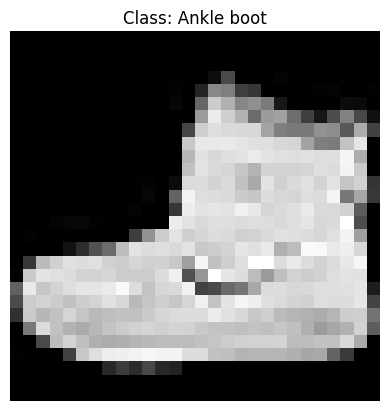

In [43]:
import matplotlib.pyplot as plt

# Suppose fashion_mnist is loaded as a dictionary with pandas DataFrames/Series
# Example class names mapping:
class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

index = 0  # Index of the image to examine

# Access image pixels as pandas Series and convert to numpy array
image_pixels = fashion_mnist['data'].iloc[index].values

# Access first pixel value
first_pixel_value = image_pixels[0]

# Access label
label = fashion_mnist['target'].iloc[index]

print(f"First image pixel array shape: {image_pixels.shape}")  # Should be (784,)
print(f"First pixel value of first image: {first_pixel_value}")
print(f"Label number: {label}")
print(f"Label name: {class_names[int(label)]}")

# Reshape to 28x28 for visualization
image_2d = image_pixels.reshape(28, 28)

# Plot the image
plt.imshow(image_2d, cmap='gray')
plt.title(f"Class: {class_names[int(label)]}")
plt.axis('off')
plt.show()


### Summary:

summary of the **Fashion MNIST dataset** :

**Fashion MNIST Dataset – Full Summary**

* **What it is**:
  A benchmark dataset for machine learning, used to train and evaluate image classification models on clothing item recognition.

* **Total Samples**: **70,000 grayscale images**

  * **60,000 training samples**
  * **10,000 test samples**

* **Image Details**:

  * Each image is **28 × 28 pixels** = **784 pixels total**
  * Stored as a **flattened 1D array of 784 values**
  * Each pixel is a **grayscale intensity**: value between **0 (black)** and **255 (white)**

* **Features**:

  * Named `pixel1`, `pixel2`, ..., `pixel784`
  * Represent the brightness level of each pixel
  * No color (only black and white shades)

* **Target Labels**:
  One label per image, from **0 to 9**, representing the clothing type

| Label | Clothing Item |
| ----- | ------------- |
| 0     | T-shirt/top   |
| 1     | Trouser       |
| 2     | Pullover      |
| 3     | Dress         |
| 4     | Coat          |
| 5     | Sandal        |
| 6     | Shirt         |
| 7     | Sneaker       |
| 8     | Bag           |
| 9     | Ankle boot    |

* **Data Format**:
  * Usually loaded as a **dictionary-like object**
  * Keys: `'data'`, `'target'`, `'feature_names'`, `'target_names'`, `'DESCR'`, etc.
  * `data` contains pixel values
  * `target` contains class labels
  * `frame` (if available) is a `pandas.DataFrame` with both




## Preparing the Fashion-MNIST dataset:

#### Min-Max normalization:
Certainly! Here's the general **min-max normalization formula**, which scales a value $x$ from its original range $[x_{\text{min}}, x_{\text{max}}]$ to a new range $[a, b]$:

$$
x_{\text{norm}} = a + \left( \frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}} \right) \times (b - a)
$$

#### Special Case: Normalize to $[-1, 1]$

$$
x_{\text{norm}} = \frac{2(x - x_{\text{min}})}{x_{\text{max}} - x_{\text{min}}} - 1
$$

#### Min-Max Normalization: From $[0, 255]$ to $[-1, 1]$

To normalize a value $x \in [0, 255]$ into the range $[-1, 1]$, you can use the **min-max normalization** formula:

Sure! To normalize a value $x \in [0, 255]$ into the range $[-1, 1]$, you use this **min-max normalization** formula:

$$
x_{\text{norm}} = \frac{2x}{255} - 1
$$

##### Explanation:

This follows directly from:

$$
x_{\text{norm}} = \frac{2(x - x_{\text{min}})}{x_{\text{max}} - x_{\text{min}}} - 1
$$

Where:

* $x_{\text{min}} = 0$
* $x_{\text{max}} = 255$

Plug in:

$$
x_{\text{norm}} = \frac{2(x - 0)}{255 - 0} - 1 = \frac{2x}{255} - 1
$$

This maps:

* $x = 0 \rightarrow -1$
* $x = 127.5 \rightarrow 0$
* $x = 255 \rightarrow +1$

In [44]:
def get_data(filter_classes):
    fashion_mnist = fetch_openml("Fashion-MNIST", parser='auto')
    x, y = fashion_mnist['data'], fashion_mnist['target'].astype(int)
    # Remove classes
    filtered_indices = np.isin(y, filter_classes)
    x, y = x[filtered_indices].to_numpy(), y[filtered_indices]
    # Normalize the pixels to be in [-1, +1] range
    x = ((x / 255.) - .5) * 2
    removed_class_count = 0
    for i in range(10):  # Fix the labels
        if i in filter_classes and removed_class_count != 0:
            y[y == i] = i - removed_class_count
        elif i not in filter_classes:
            removed_class_count += 1
    # Do the train-test split
    return train_test_split(x, y, test_size=10_000)

## Loading the Fashion-MNIST Dataset:

In [21]:
def onehot_encoder(y, num_labels):
    one_hot = np.zeros(shape=(y.size, num_labels), dtype=int)
    one_hot[np.arange(y.size), y] = 1
    return one_hot

class_names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover',
               3: 'Dress', 4: 'Coat', 5:  'Sandal', 6: 'Shirt',
               7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

kept_classes = [0, 1, 7] #t_shirt, trouser, sneaker

x_train, x_test, y_train, y_test = get_data(kept_classes)

# One-hot encode the target labels of the training set
y_train = onehot_encoder(y_train, num_labels=len(kept_classes))

## Training the Network

  0%|          | 0/30 [00:00<?, ?it/s]

Loss: 0.056: 100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


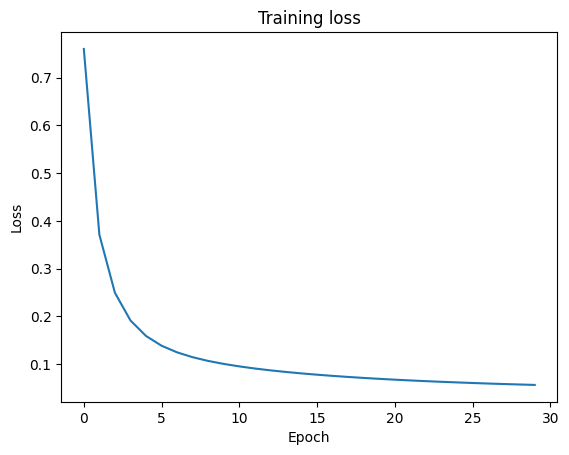

In [53]:

def plot_training(losses):
    # Plot the loss
    plt.plot(losses)
    plt.title("Training loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

layers = [Linear(784, 50),
          ReLU(),
          Linear(50, 50),
          ReLU(),
          Linear(50, len(kept_classes)),
          Softmax()]

model = MLP(layers, CrossEntropy(), learning_rate=0.001) 

# Train the model
losses = model.train(x_train, y_train, epochs=30, batch_size=64)

plot_training(losses)
